In [1]:
from dotenv import load_dotenv
load_dotenv()

True

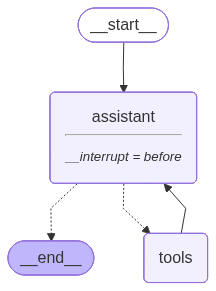

In [15]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

def tyre_strat(Laps_Remaining: int,Laps_Done: int,Safety_Car: bool,drivability: bool) -> str:
    """
    This is used to suggest if the Driver needs to Box and Change Tyres
    """
    if Laps_Done > 15  :
        return "Box for New Hards"
    elif not drivability:
        return "Change Tyres"
    elif (Laps_Remaining<15 and Safety_Car):
        return "Box for a set of Softs and time to Turn and Burn"
    else:
        return "Stay Out!! Stay Out!! Stay Out!!"

def Wet_Condition(is_raining: bool,drivability: bool) -> str:
    """
    If there exists a wet condition use this
    """
    if drivability:
        return "Let's drive in until the brink of toughness"
    elif is_raining and (not drivability):
        return "Box for Wets and Unleash Hell"
    else:
        return "Stay Out!! Stay Out!! Stay Out!!"


tools = [tyre_strat,Wet_Condition]
llm = ChatOpenAI(model="gpt-5-nano-2025-08-07")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a F1 Race Engineer to driver and help the driver")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": "Box for new softs the Car is swinging like crazy"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

state = graph.get_state(thread)
state

In [21]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="It's raining and I am starting to lose grip of the car")]},
)

new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Box for new softs the Car is swinging like crazy
================================ Human Message =================================

It's raining and I am starting to lose grip of the car


In [22]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

It's raining and I am starting to lose grip of the car
================================== Ai Message ==================================
Tool Calls:
  Wet_Condition (call_5iT6DFHBe9Uz8lQh1qmz1nF7)
 Call ID: call_5iT6DFHBe9Uz8lQh1qmz1nF7
  Args:
    is_raining: True
    drivability: False
================================= Tool Message =================================
Name: Wet_Condition

Box for Wets and Unleash Hell
